## 고객의 전체 모습을 파악하는 테크닉 10

### 데이터를 읽어 들이고 확인하자

In [3]:
import pandas as pd
uselog = pd.read_csv('data/chap03/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [4]:
customer = pd.read_csv('data/chap03/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [5]:
class_master = pd.read_csv('data/chap03/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [6]:
campaign_master = pd.read_csv('data/chap03/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


### 고객 데이터를 가공하자

* `merge`: 중심이 되는 데이터를 바탕으로 **가로**로 결합

In [7]:
customer_join = pd.merge(customer, class_master, on='class', how='left')
customer_join = pd.merge(customer_join, campaign_master, on='campaign_id', how='left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [8]:
print(len(customer))
print(len(customer_join))

4192
4192


#### `join` 이후 결측치를 확인합니다.

In [9]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### 고객 데이터를 집계하자

In [10]:
customer_join.groupby('class_name').count()['customer_id']

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [11]:
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

In [12]:
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [13]:
customer_join.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [14]:
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))
print(len(customer_join))

1361
4192


### 최신 고객 데이터를 집계하자

In [15]:
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_newer = customer_join.loc[(customer_join['end_date'] >= pd.to_datetime('20190331'))
        | (customer_join['end_date'].isna())]
print(len(customer_newer)) # end-date가 2019년 03월 31일 이후인 회원들의 수
customer_newer['end_date'].unique()

2953


<DatetimeArray>
['NaT', '2019-03-31 00:00:00']
Length: 2, dtype: datetime64[ns]

In [16]:
customer_newer.groupby('class_name').count()['customer_id']

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [17]:
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [18]:
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### 이용 이력 데이터를 집계하자

In [19]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [20]:
uselog_customer = uselog_months.groupby('customer_id').agg({'count': ['mean', 'median', 'max', 'min']})
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

customer_id     count               
                   mean median max min
0    AS002855  4.500000    5.0   7   2
1    AS008805  4.000000    4.0   8   1
2    AS009013  2.000000    2.0   2   2
3    AS009373  5.083333    5.0   7   3
4    AS015233  7.545455    7.0  11   4

In [21]:
uselog.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


### 이용 이력 데이터로부터 정기 이용 플래그를 작성하자

In [22]:
uselog['weekday'] = uselog['usedate'].dt.weekday
uselog_weekday = uselog.groupby(['customer_id', '연월', 'weekday'],
                               as_index=False).count()[['customer_id', '연월', 'weekday', 'log_id']]
uselog_weekday.rename(columns={'log_id': 'count'}, inplace=True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [23]:
uselog_weekday = uselog_weekday.groupby('customer_id', as_index=False).max()[['customer_id', 'count']]
uselog_weekday['routine_flg'] = 0
uselog_weekday['routine_flg'] = uselog_weekday['routine_flg'].where(uselog_weekday['count']<4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### 고객 데이터와 이용 이력 데이터를 결합하자

In [24]:
uselog_customer.head()
uselog_customer.columns = ['customer_id', 'mean', 'median', 'max', 'min']

In [25]:
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


In [26]:
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [27]:
customer_join = pd.merge(customer_join, uselog_customer, on='customer_id', how='left')
customer_join = pd.merge(customer_join, uselog_weekday[['customer_id', 'routine_flg']],
                        on='customer_id', how='left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [28]:
customer_join.columns

Index(['customer_id', 'name', 'class', 'gender', 'start_date', 'end_date',
       'campaign_id', 'is_deleted', 'class_name', 'price', 'campaign_name',
       'mean', 'median', 'max', 'min', 'routine_flg'],
      dtype='object')

#### `join` 이후 결측치 확인

In [29]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

### 회원 기간을 계산하자

In [30]:
from dateutil.relativedelta import relativedelta
customer_join['calc_date'] = customer_join['end_date']
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430'))
customer_join['membership_period'] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_date'].iloc[i], customer_join['start_date'].iloc[i])
    customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months
customer_join.head()

C:\Users\thddl\AppData\Local\Temp\ipykernel_28860\2375658800.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months
C:\Users\thddl\AppData\Local\Temp\ipykernel_28860\237

### 고객 행동의 각종 통계량을 파악하자

In [31]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [32]:
customer_join.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

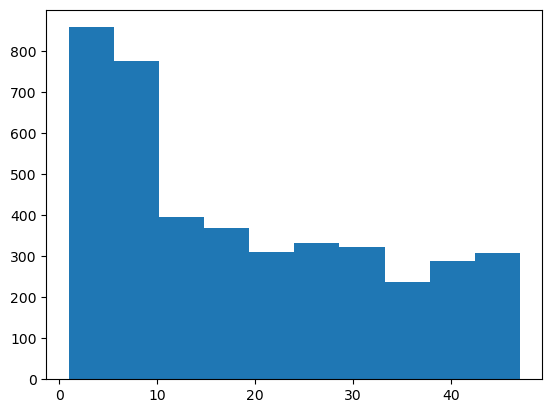

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join['membership_period'])

### 탈퇴 회원과 지속 회원의 차이를 파악하자

In [35]:
customer_end = customer_join.loc[customer_join['is_deleted'] == 1]
customer_end.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_flg,calc_date,membership_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,2018-10-17 16:23:28,8.026667
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,2018-06-30 00:00:00,4.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,2018-10-31 00:00:00,7.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,2019-01-31 00:00:00,11.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,2019-03-31 00:00:00,23.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,NaN,5.033692


In [36]:
customer_stay = customer_join.loc[customer_join['is_deleted']==0]
customer_stay.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_flg,calc_date,membership_period
count,2842,0,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842,2842.000000
mean,2017-04-03 22:42:28.627726848,NaT,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,2019-04-30 00:00:00,23.970443
min,2015-05-01 00:00:00,NaT,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,2019-04-30 00:00:00,1.000000
25%,2016-05-01 00:00:00,NaT,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,2019-04-30 00:00:00,12.000000
50%,2017-04-01 00:00:00,NaT,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,2019-04-30 00:00:00,24.000000
75%,2018-04-05 00:00:00,NaT,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,2019-04-30 00:00:00,35.000000
max,2019-03-15 00:00:00,NaT,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,2019-04-30 00:00:00,47.000000
std,NaN,NaN,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,NaN,13.746761


In [37]:
customer_join.to_csv('customer_join.csv', index=False)